In [9]:
!pip install seaborn scikit-fuzzy



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\aulde\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
# Import semua library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Setup visualisasi
sns.set(style="whitegrid")
np.random.seed(42)


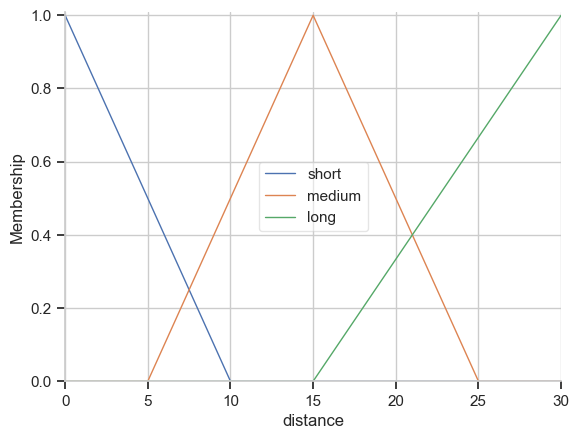

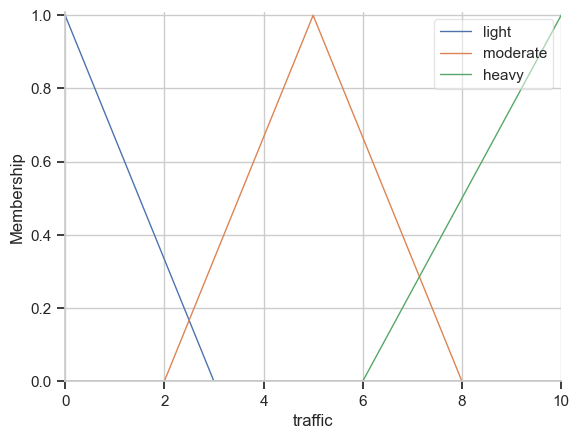

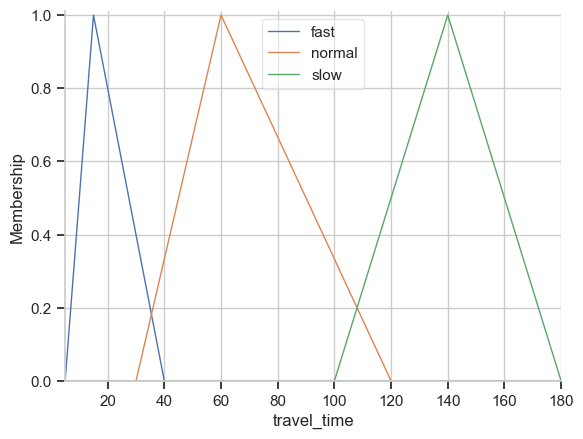

In [11]:
# Definisi variabel input & output
distance = ctrl.Antecedent(np.arange(0, 31, 1), 'distance')      # km
traffic  = ctrl.Antecedent(np.arange(0, 11, 1), 'traffic')       # 0–10
travel_time = ctrl.Consequent(np.arange(5, 181, 1), 'travel_time')  # menit

# Membership Function: Distance
distance['short']  = fuzz.trimf(distance.universe, [0, 0, 10])
distance['medium'] = fuzz.trimf(distance.universe, [5, 15, 25])
distance['long']   = fuzz.trimf(distance.universe, [15, 30, 30])

# Membership Function: Traffic
traffic['light']    = fuzz.trimf(traffic.universe, [0, 0, 3])
traffic['moderate'] = fuzz.trimf(traffic.universe, [2, 5, 8])
traffic['heavy']    = fuzz.trimf(traffic.universe, [6, 10, 10])

# Membership Function: Travel Time
travel_time['fast']   = fuzz.trimf(travel_time.universe, [5, 15, 40])
travel_time['normal'] = fuzz.trimf(travel_time.universe, [30, 60, 120])
travel_time['slow']   = fuzz.trimf(travel_time.universe, [100, 140, 180])

# Visualisasi
distance.view()
traffic.view()
travel_time.view()


In [12]:
# Definisikan aturan fuzzy
r1 = ctrl.Rule(distance['short'] & traffic['light'], travel_time['fast'])
r2 = ctrl.Rule(distance['short'] & traffic['moderate'], travel_time['normal'])
r3 = ctrl.Rule(distance['short'] & traffic['heavy'], travel_time['normal'])

r4 = ctrl.Rule(distance['medium'] & traffic['light'], travel_time['normal'])
r5 = ctrl.Rule(distance['medium'] & traffic['moderate'], travel_time['normal'])
r6 = ctrl.Rule(distance['medium'] & traffic['heavy'], travel_time['slow'])

r7 = ctrl.Rule(distance['long'] & traffic['light'], travel_time['normal'])
r8 = ctrl.Rule(distance['long'] & traffic['moderate'], travel_time['slow'])
r9 = ctrl.Rule(distance['long'] & traffic['heavy'], travel_time['slow'])

# Gabungkan ke sistem kontrol
system = ctrl.ControlSystem([r1, r2, r3, r4, r5, r6, r7, r8, r9])
sim = ctrl.ControlSystemSimulation(system)


In [13]:
# Generate dataset sederhana
n = 100
distances = np.round(np.random.uniform(1, 30, n), 2)
traffics  = np.round(np.random.uniform(0, 10, n), 2)

df = pd.DataFrame({
    'distance_km': distances,
    'traffic_index': traffics
})

# Jalankan fuzzy inference
travel_times = []
for d, t in zip(df['distance_km'], df['traffic_index']):
    sim.input['distance'] = d
    sim.input['traffic'] = t
    sim.compute()
    travel_times.append(sim.output['travel_time'])

df['est_travel_time_min'] = np.round(travel_times, 2)

# Insight baru: kategori risiko keterlambatan
def risk_label(x):
    if x <= 30:
        return 'Low'
    elif x <= 90:
        return 'Medium'
    else:
        return 'High'

df['late_risk'] = df['est_travel_time_min'].apply(risk_label)
df.head()


,distance_km,traffic_index,est_travel_time_min,late_risk
0,11.86,0.31,70.75,Medium
1,28.57,6.36,140.00,High
2,22.23,3.14,108.78,High
3,18.36,5.09,89.86,Medium
4,5.52,9.08,78.98,Medium


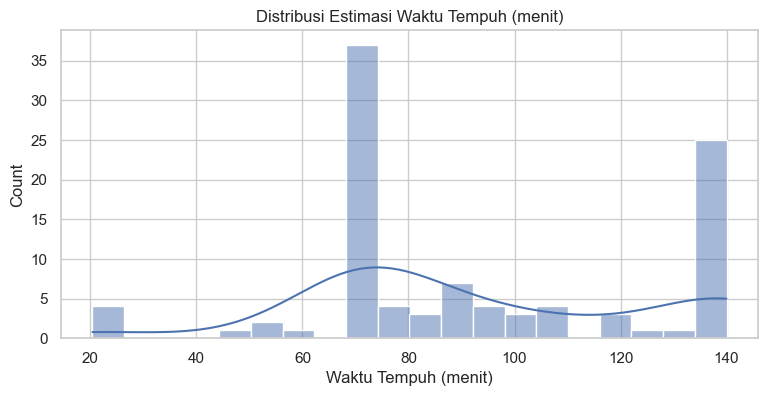

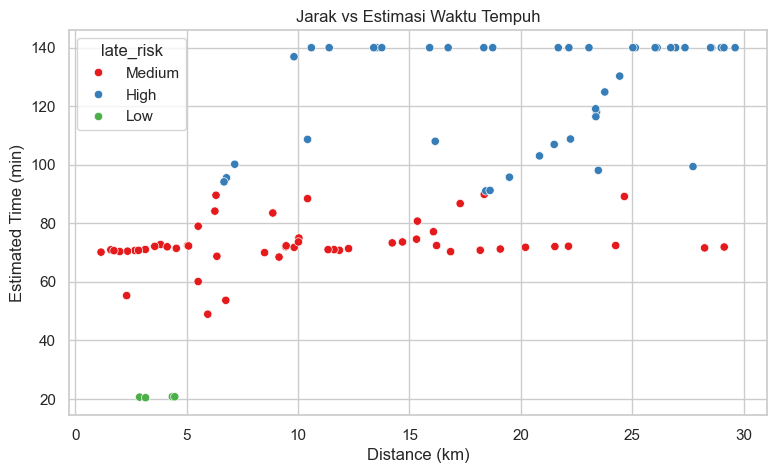

In [14]:
# Plot distribusi waktu tempuh
plt.figure(figsize=(9,4))
sns.histplot(df['est_travel_time_min'], bins=20, kde=True)
plt.title('Distribusi Estimasi Waktu Tempuh (menit)')
plt.xlabel('Waktu Tempuh (menit)')
plt.show()

# Scatter jarak vs waktu tempuh
plt.figure(figsize=(9,5))
sns.scatterplot(data=df, x='distance_km', y='est_travel_time_min', hue='late_risk', palette='Set1')
plt.title('Jarak vs Estimasi Waktu Tempuh')
plt.xlabel('Distance (km)')
plt.ylabel('Estimated Time (min)')
plt.show()


In [15]:
# Simpan hasil dataset
df.to_csv('fuzzy_travel_dataset.csv', index=False)

# Buat requirements.txt
reqs = """numpy
pandas
matplotlib
seaborn
scikit-fuzzy
"""
with open('requirements.txt', 'w') as f:
    f.write(reqs)

# Buat deskripsi project
desc = f"""
Project: Estimasi Waktu Tempuh dengan Fuzzy Logic
Dataset: {len(df)} baris data
Input: distance_km, traffic_index
Output: est_travel_time_min (menit)
Insight: late_risk (Low / Medium / High)

Membership Function:
- distance: short [0-10], medium [5-25], long [15-30]
- traffic: light [0-3], moderate [2-8], heavy [6-10]
- travel_time: fast [5-40], normal [30-120], slow [100-180]
"""
with open('project_description.txt', 'w') as f:
    f.write(desc)

print("✅ File berhasil disimpan: fuzzy_travel_dataset.csv, requirements.txt, project_description.txt")


✅ File berhasil disimpan: fuzzy_travel_dataset.csv, requirements.txt, project_description.txt
